# Ballistic Precision & Accuracy

We want to describe the accuracy of guns in ways that are rigorous and useful.  A gun is any system that launches a projectile (e.g., a bullet or missile) into ballistic flight.  Typically, the purpose of the gun is to cause the projectile to follow a specific trajectory that intersects a target at some distance.  A lot of the science of ballistics is devoted to maximizing the precision with which a gun can hit a target.

Here we will study statistical models of ballistic precision.  The models will give us a detailed understanding of what we can say about any particular gun's ability to hit targets.  At each step, we will use "Monte Carlo" simulation techniques to validate the mathematics.

## Normal Distribution in 1 dimension

When we look at the ballistic trajectory of many bullets fired from the same gun at the same point, we find that they have some dispersion.  We can stick a target in the path of the trajectory and look at where on the target each bullet crosses.  We'll record the coordinates of where each shot hits the target, and discover that when we look at the horizontal and vertical coordinates they are precisely modelled by the normal distribution.

The normal distribution also models another variable of interest in ballistics: Muzzle velocity.

The normal distribution depends on two parameters: mean ($\mu$) and variance ($\sigma^2$).  In order to use the normal distribution to model a specific process of interest – say, the muzzle velocity of a batch of ammunition fired from a particular rifle; or the x-coordinates of bullet holes in a target – we have to determine the mean and variance that apply to that rifle and ammunition.

### [Determining mean and variance](https://docs.google.com/spreadsheets/d/1i_trin4mHuTJI4HnAnPiVwJHMc0m0X09E7Ya7_aWGFQ/edit?usp=sharing)
We determine the parameters based on samples of the values actually produced by the process.

Let's consider the muzzle velocity *V* of a particular gun shooting a particular lot of ammunition.  We assume (based on general arguments of physics and statistics that we won't get into here) that $V \sim N(\mu_V, \sigma_V)$.  At the outset we don't know the value of those parameters, $\mu_V$ and $\sigma_V$.  To find them we begin to collect data: We have a chronograph to measure the muzzle velocity of each shot, so we can keep shooting to collect sample muzzle velocity values ${v_i}$.

#### Estimating mean
Our best guess of the true mean value is just the mean value of the samples.  I.e., given *n* samples we estimate that $\mu_V = \bar{v}= \frac{\sum{v_i}}{n}$.

#### Estimating variance
An unbiased guess of the true variance is $\hat{\sigma}^2 = s^2 = \frac{1}{n-1}\sum{(v_i - \bar{v})^2}$.  (For clarity it is common to use the letter *s* to denote an estimate of the true value $\sigma$, or to adorn the parameter with a "hat" as $\hat{\sigma}$.)

#### Estimating standard deviation
Given the true value of the variance, the standard deviation $\sigma$ is just the square root of variance $\sigma^2$: i.e.,  $\sigma = \sqrt{\sigma^2}$.  But when estimating these parameters based on samples there is some bias produced by taking the square root, and it can be significant when the number of samples available is small (like single-digit small).  To remove that bias we need a correction factor: The Gaussian correction term $c_G(n)$, which depends on the number of samples used to compute the estimate, is defined as:
$$\frac{1}{c_G(n)} = c_4(n) = \sqrt{\frac{2}{n-1}}\,\,\,\frac{\Gamma\left(\frac{n}{2}\right)}{\Gamma\left(\frac{n-1}{2}\right)}$$

and our unbiased estimate of standard deviation is:
$$\hat{\sigma} = s = c_G(n)\sqrt{s^2}$$


#### Confidence in the estimates

How good is our estimate?  In statistics we talk about "Confidence Intervals," which are a good expression of our confidence (or, conversely, *uncertainty*) in our estimate.  We can calculate the Confidence Interval for a particular level of significance $p \in (0,1)$.  (It is common in the literature to see confidence defined for the complement of p: $\alpha = 1-p$.)

But the term "confidence" is often misused, so to be precise in our definition of a Confidence Interval: Let *X* be a random variable with some unknown parameter.  Now do an experiment:
* Collect *n* samples of *X*
* Compute the parameter estimate.  (For example, estimated mean $\bar{X} = \frac{\sum{x_i}}{n}$.)
* Compute the Confidence Interval at level *p%* of that estimate: [$\bar{X}_L, \bar{X}_U$].
We can do this experiment many times.  We will find that the Confidence Interval covers the true value of the parameter in exactly *p%* of such experiments.

How do we know the *true* value of the parameter we're estimating?  In practice we often do not, which is the whole point of doing experiments and making estimates.  But we can verify that this math is correct by doing controlled experiments in which we do know the true value.  We will do that in the next section **Validation by Simulation**.

##### Confidence Interval for Mean
First, here's the formula for the Confidence Interval of the estimated mean:
$$[\bar{X}-\frac{s}{\sqrt{n}}t_{\frac{\alpha}{2},n-1}, \bar{X}+\frac{s}{\sqrt{n}}t_{\frac{\alpha}{2},n-1}]$$
The key terms here come from:
* The *t*-distribution with *n*-1 degrees of freedom.
* The *standard error of the mean*, which is $\frac{s}{\sqrt{n}}$.  An important consequence of this term is that, holding all else equal, **the error in estimating the mean scales with the square root of the number of samples**.  So, for example: to cut the error around an estimated mean by a factor of 2, we need to collect 4 times as many sample points.

##### Confidence Interval for Variance
$$[\frac{(n-1)s^2}{\chi^2_{\frac{\alpha}{2},n-1}},\frac{(n-1)s^2}{\chi^2_{1-\frac{\alpha}{2},n-1}}]$$
The key term here comes from the $\chi^2$-distribution with *n*-1 degrees of freedom.

### Example

In [19]:
import math
import numpy as np
from scipy.stats.distributions import chi2, t

def cGauss(d: int) -> float:
    """Gaussian correction factor with d degrees of freedom"""
    return 1/math.exp(math.log(math.sqrt(2/(d-1))) + math.lgamma(d/2) - math.lgamma((d-1)/2))

# Simulation of muzzle velocity inference
mean = 3000
stdev = 20
n = 10      # Number of samples to take
p = 0.9     # Confidence level for which we want Confidence Intervals
samples = np.random.normal(loc=mean, scale=stdev, size=n)
sampleMean = np.mean(samples)
sampleVariance = np.var(samples, ddof=1)
sampleStdevBiased = math.sqrt(sampleVariance)
sampleStdev = cGauss(n) * sampleStdevBiased
stdErr = sampleStdevBiased/math.sqrt(n)
confidenceMean = np.array(t.interval(p, df=n-1, loc=sampleMean, scale=stdErr))
confidenceVar = np.divide((n-1)*sampleVariance, chi2.interval(p, df=n-1))[::-1]
confidenceStdev=cGauss(n)*np.sqrt(confidenceVar)
print(f'Sample mean={sampleMean:.1f} with {p:.0%} confidence interval {np.array2string(confidenceMean, formatter={"float": lambda x: f"{x:.1f}"}, separator=", ")}\n'
      f'Sample var={sampleVariance:.1f} with {p:.0%} confidence interval {np.array2string(confidenceVar, formatter={"float": lambda x: f"{x:.0f}"}, separator=", ")}\n'
      f'Sample stdev={sampleStdev:.2f} with {p:.0%} confidence interval {np.array2string(confidenceStdev, formatter={"float": lambda x: f"{x:.1f}"}, separator=", ")}')
# Optionally copy the samples to clipboard:
import pandas as pd
pd.DataFrame(samples).to_clipboard()

Sample mean=3005.9 with 90% confidence interval [2992.6, 3019.2]
Sample var=524.4 with 90% confidence interval [279, 1419]
Sample stdev=23.54 with 90% confidence interval [17.2, 38.7]


In [46]:
chi2.interval(p, df=n-1)

(3.3251128430668144, 16.918977604620448)

### Validation by Simulation

In [18]:
mean = 3000
stdev = 20
numSims = 50_000
n = 5      # Number of samples per simulation
p = 0.9     # Confidence level for which we want Confidence Intervals
variance = stdev**2
cG = cGauss(n)
chi2Interval = np.divide((n-1), chi2.interval(p, df=n-1))[::-1]
samples = np.random.normal(loc=mean, scale=stdev, size=(numSims, n))
sampleMean = np.zeros(numSims)
sampleVariance = np.zeros(numSims)
sampleStdevBiased = np.zeros(numSims)
sampleStdev = np.zeros(numSims)
countMeanInInterval = 0  # Count number of times the true mean is in the mean confidence interval
countVarInInterval = 0  # Count number of times the true variance is in the var confidence interval

for i in range(numSims):
    sampleMean[i] = np.mean(samples[i])
    sampleVariance[i] = np.var(samples[i], ddof=1)
    sampleStdevBiased[i] = math.sqrt(sampleVariance[i])
    sampleStdev[i] = cG * sampleStdevBiased[i]
    stdErr = sampleStdevBiased[i]/math.sqrt(n)
    confidenceMean = np.array(t.interval(p, df=n-1, loc=sampleMean[i], scale=stdErr))
    if confidenceMean[0] < mean < confidenceMean[1]:
        countMeanInInterval += 1
    confidenceVar = sampleVariance[i] * chi2Interval
    if confidenceVar[0] < variance < confidenceVar[1]:
        countVarInInterval += 1

print(f'Over {numSims:,} simulations of {n}-sample groups from N({mean}, {stdev}), with {p:.0%} confidence ranges:\n'
      f'\tAvg sample mean = {np.mean(sampleMean):.1f}.  True mean in confidence range {countMeanInInterval/numSims:.1%} of the time\n'
      f'\tAvg sample var = {np.mean(sampleVariance):.1f}.  True variance in confidence range {countVarInInterval/numSims:.1%} of the time\n'
      f'\tAvg biased stdev = {np.mean(sampleStdevBiased):.2f}.  Avg unbiased stdev = {np.mean(sampleStdev):.2f}')

Over 50,000 simulations of 5-sample groups from N(3000, 20), with 90% confidence ranges:
	Avg sample mean = 2999.9.  True mean in confidence range 90.2% of the time
	Avg sample var = 397.8.  True variance in confidence range 90.0% of the time
	Avg biased stdev = 18.76.  Avg unbiased stdev = 19.96


## Normal Distribution in 2 dimensions

When looking at shots on a target, there are two variables that follow a normal distribution: The location of each shot on the horizontal "x" axis (the *x coordinate*), and the location of each shot on the vertical "y" axis (the *y coordinate*).

(In ballistics we do not see correlation between the x- and y- coordinates, so correlation and covariances between these two variables are always zero.)

Though we often find that $\sigma_x = \sigma_y$, this is not necesssarily the case.  So how do we determine whether $\sigma_x = \sigma_y$?

There are statistical tests for this, but they are not very powerful on the sample sizes typically available to shooters.  When it comes to ballistics, we know what phenomena can cause asymmetric variance: variable crosswind causes excess horizontal variance, and variations in muzzle velocity cause asymmetric vertical variance longer ranges.  Using a ballistic calculator we can check whether the variation in crosswind or muzzle velocity are large enough to show up as excess variance on a target for the gun and distance we are shooting.  (We can even use a calculator to remove those factors.)  I prefer to assume that $\sigma_x = \sigma_y$ unless these physics tell us that we should expect them to be significantly unequal.

### Test for equal variances
Following code shows two standard tests for homoscedasticity (i.e., equal variances): The F-test and Bartlett's test.

In [3]:
# Tests for equality of variances
import numpy as np
from scipy.stats import chi2, f, bartlett
n = 10  # Number of samples to draw from each random variable
p = .9
chi2Interval = np.divide((n-1), chi2.interval(p, df=n-1))[::-1]
sigmaX = 1
sigmaY = 2
X = np.random.normal(scale=sigmaX, size=n)
Y = np.random.normal(scale=sigmaY, size=n)
varX = np.var(X, ddof=1)
varY = np.var(Y, ddof=1)
confidenceVarX = varX * chi2Interval
confidenceVarY = varY * chi2Interval
F = varX / varY
p_valueF = 2 * f.cdf(F, n-1, n-1)  # Two-tailed F-test
bstat, p_valueB = bartlett(X, Y)
print(f'Sample VarX={varX:.2f} with {p:.0%} confidence interval {np.array2string(confidenceVarX, formatter={"float": lambda x: f"{x:.2f}"}, separator=", ")}\n'
      f'Sample VarY={varY:.2f} with {p:.0%} confidence interval {np.array2string(confidenceVarY, formatter={"float": lambda x: f"{x:.2f}"}, separator=", ")}\n'
      f'F-test gives probability these samples came from variables with equal variance of {p_valueF:0.1%}\n'
      f'Bartlett gives probability these samples came from variables with equal variance of {p_valueB:0.1%}')

Sample VarX=0.56 with 90% confidence interval [0.30, 1.52]
Sample VarY=4.64 with 90% confidence interval [2.47, 12.55]
F-test gives probability these samples came from variables with equal variance of 0.4%
Bartlett gives probability these samples came from variables with equal variance of 0.4%


The advantage of assuming $\sigma_x = \sigma_y$ is that we only have to work with a single parameter ($\sigma$) when measuring and describing precision.  With fewer parameters to estimate, we use our sample data more efficiently and our model becomes more powerful.

### If we erroneously assume equal variances

If we incorrectly assume $\sigma_x = \sigma_y$, then our predictions will have some error.  Turns out that the error is small when the difference in the variances is small.  See §"Error from single sigma estimate" below.

# [Ballistic precision](http://ballistipedia.com/index.php?title=Closed_Form_Precision) from sample targets.

We define a class `Group` that holds data on a group of shots on a target.  The shot data can be provided as a collection of (x, y) coordinates of each shot as recorded on a real target.  Or the class can generate a group by simulating random shots from a gun with a specified precision (using parameter `sigma`).

Using the shot data, `Group` calculates statistics and estimates of precision:
* Sigma, the Rayleigh distribution parameter (which also corresponds to the bivariate normal distribution with standard deviation = sigma)
* The confidence interval on the estimate of sigma
* Extreme Spread
* If the group was simulated, then we can also calculate the distance from the sample center to the true (known) center

A `plotGroup` class provides a more detailed plot of a Group than the `.plot()` method provided in the `Group` class.

We later define an `OrderStatistics` subclass of `Group` that uses Order Statistics to estimate sigma.  This is a less efficient estimator, but can be easier to calculate because it doesn't require measuring the coordinates of every shot in the group.  However we have only derived Order Statistic estimators for groups of size 3, 5, or 10 shots.

We use "Monte Carlo" simulation to validate the statistical estimators.  Here's how that technique works: we generate large numbers of random groups using a particular parameter value, and then look at the calculated statistics to verify that they match that parameter's value.  For example, we could ask: *Is our estimator of sigma correct?*  Let's check by simulating a million groups, where each shot in each group is generated from a random variable with sigma = 1.  Calculate our sigma estimate on each group, and then look at the average of those estimates.  If our estimator is correct then its average over a large number of samples should match the parameter used to construct the samples.  So, in this example, if the average estimate of sigma is 1 then we can be confident that our estimator is correct.

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2

In [63]:
class Group:
    """
    Data on a group of shots.
    Computes statistical estimates of precision based on the shot data.
    """
    n: int                              # Number of shots in group
    sigma: float                        # Standard deviation to use if simulating shots with random variables
    degrees: int                        # Degrees of freedom (for estimators)
    shots: list[list[float]]            # Coordinates of shots [[x, y], [x, y], ...]
    sampleCenter: [float, float]        # Coordinates of centroid of group
    centeredShots: list[list[float]]    # Shots shifted so that their centroid coordinates = (0,0)
    radii: list[float]                  # Radius (distance) of each shot from centroid
    sumR2: float                        # Sum of radii squared
    sigmaEstimate: float                # Unbiased Rayleigh parameter estimate
    confidenceInterval: float           # Confidence region to calculate; default is 90%
    sigmaUpperConfidence: float         # Upper bound of confidenceInterval on sigmaEstimate
    varianceX: float                    # Sample estimate of variance along x axis
    varianceY: float                    # Sample estimate of variance along y axis
    stdevX: float                       # Unbiased estimate of x-axis stdev = sqrt(varianceX)*cG(n)
    stdevY: float                       # Unbiased estimate of y-axis stdev = sqrt(varianceY)*cG(n)

    def __init__(self, n: int, shots: list[list[float]]=[], sigma: float=1.0, confidenceInterval: float=0.9):
        """
        If no shot data provided then all simulation samples will be drawn from X,Y ~ N(0,sigma)
        in which case we know the true parameter we're estimating is sigma (with center at the origin)       

        :param n: Number of shots
        :param shots: List of (x,y) coordinates of each shot impact on target.
        :param sigma: standard deviation to use if simulating shots.
        :param confidenceInterval: Confidence region to calculate. Allowed range is (0,1). Default is 90%.
        """
        self.sigma = sigma
        if len(shots) > 0:
            self.shots = shots
            self.n = len(shots)
        else:  # If we didn't receive a group of shots then create random shots from bivariate normal distribution
            self.shots = np.random.normal(scale=sigma, size=(n,2))
            self.n = n

        #region Univariate measures
        a = np.array(self.shots)
        self.varianceX = np.var(a[:,0], ddof=1)
        self.varianceY = np.var(a[:,1], ddof=1)
        cG = Group.cGauss(self.n)
        self.stdevX = math.sqrt(self.varianceX) * cG
        self.stdevY = math.sqrt(self.varianceY) * cG
        #endregion

        g = 1  # Number of groups
        self.degrees = 2*(self.n-g)  # Degrees of freedom (for estimators)
        self.sampleCenter = np.mean(self.shots, axis=0)
        self.centeredShots = np.add(self.shots, -self.sampleCenter) # Shots adjusted so their centroid = (0,0)
        self.radii = np.linalg.norm(self.centeredShots, axis=-1)    # List of radii from sample center
        self.sumR2 = np.dot(self.radii, self.radii)
        self.sigmaEstimate = Group.cGauss(self.degrees+1) * math.sqrt(self.sumR2 / self.degrees)  # Unbiased Rayleigh parameter estimate
        self.confidenceInterval = confidenceInterval
        self.sigmaUpperConfidence = math.sqrt(self.sumR2 / chi2.ppf((1-confidenceInterval)/2, self.degrees))  # Upper bound of confidence interval on estimate

        # Distance from sample center to origin (0,0)
        # CAVEAT: The origin is only known to be the *true center* if the shots were generated from Normal variables with mean = 0
        self.d2c = math.sqrt(np.dot(self.sampleCenter, self.sampleCenter))
        # Median expected distance from sample center to true center = cR * sqrt(2*math.log(2)) * sigmaEstimate / sqrt(n)
        self.d2cMedian = Group.cRayleigh(self.degrees+1) * 1.177410022515474 * self.sigmaEstimate / math.sqrt(self.n)

    cGmem = {}  # Memoized Gaussian correction factor
    def cGauss(d: int) -> float:
        """Gaussian correction factor with d degrees of freedom"""
        if d not in Group.cGmem:
            Group.cGmem[d] = 1/math.exp(math.log(math.sqrt(2/(d-1))) + math.lgamma(d/2) - math.lgamma((d-1)/2))
        return Group.cGmem[d]
    
    cRmem = {}  # Memoized Rayleigh correction factor
    def cRayleigh(d: int) -> float:
        """Rayleigh correction factor with d degrees of freedom"""
        if d not in Group.cRmem:
            Group.cRmem[d] = math.exp(math.log(math.sqrt(d/math.pi)) + d * math.log(4) + math.lgamma(d+1) + math.lgamma(d) - math.lgamma(2*d+1))
        return Group.cRmem[d]

    def plot(self):
        """Display plot of shots.  Can call .savefig() on return value to output to file."""
        range = 1.1 * np.max(np.abs(self.shots))  # Make plot range large enough to show all shots
        plt.scatter(*zip(*self.shots))
        plt.xlim(-range, range)
        plt.ylim(-range, range)
        plt.gca().set_aspect('equal')
        plt.show()

    #region Group Measures
    # Compute Extreme Spread of Group – max Euclidean distance between any two points
    # This is a brute-force algorithm. (Fastest algorithm: Find convex hull, then use Shamos's Rotating Calipers algorithm.)
    def extremeSpread(self) -> float:
        maxSpread = 0
        for i in range(0, self.n):
            for j in range(i+1, self.n):
                spread = sum(np.square(self.shots[i] - self.shots[j]))  # Sum squared distance
                if spread > maxSpread:
                    maxSpread = spread
        return math.sqrt(maxSpread)
    #endregion

In [64]:
g = Group(10)
np.mean(g.shots, axis=0)

array([0.4666843 , 0.19488336])

### Generate and plot random group

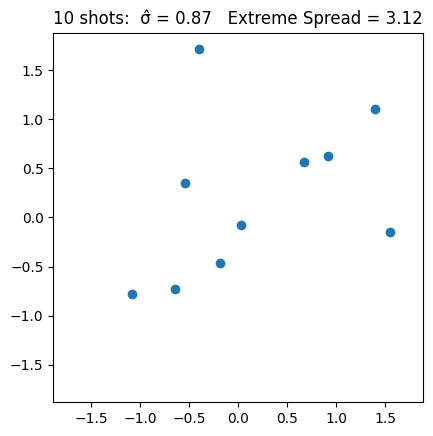

In [65]:
g = Group(10)
plt.title(f"{g.n} shots:  \u03C3\u0302 = {g.sigmaEstimate:.2f}   Extreme Spread = {g.extremeSpread():.2f}")
g.plot()

### Fancy Plot

In [18]:
import matplotlib.ticker as plticker

class plotGroup():
    def __init__(self, g: Group, CEP: float=0.5, figSize: float=1, fixedWidth: float=0):
        shots = g.shots
        center = g.sampleCenter

        self.fig = plt.figure(figsize=[figSize, figSize])

        # CEP(F) = sigma sqrt(-2 ln(1-F))
        CEPradius = math.sqrt(-2.0 * math.log(1.0-CEP)) * g.sigmaEstimate

        if fixedWidth > 0:
            width = fixedWidth
        else:
            outside = max(abs(center[0]), abs(center[1])) + CEPradius  # Range needed to fit full CEP circle on plot
            width = 1.1*max(np.max(np.abs(shots)), math.ceil(outside))  # Fit all shots as well as CEP circle
        ax = plt.axes([-width, -width, 2*width, 2*width], xlim=(-width, width), ylim=(-width, width))
        for s in ax.spines.values():
            s.set_color([0,0,0,.5])
        ax.axhline(0, color='k', lw=0.75, zorder=1)
        ax.axvline(0, color='k', lw=0.75, zorder=1)
        # Set grid frequency to integers
        gridFreq = plticker.MultipleLocator(base=1.0)
        ax.xaxis.set_major_locator(gridFreq)
        ax.yaxis.set_major_locator(gridFreq)
        ax.set_axisbelow(True)  # Grid lines behind other elements        
        ax.tick_params(labelbottom=False, labelleft=False, length=0)  # Don't show tick labels
        plt.grid()

        # Size for bullet holes
        points_whole_ax = figSize * 72 * width    # 1 point = dpi / 72 pixels
        bulletRadius = 0.04
        points_radius = 2 * bulletRadius * points_whole_ax
        # Plot Shots:
        ax.scatter(*zip(*shots), s=points_radius**2, color=[1,0,0,1], zorder=2)
        # Mark center of group:
        ax.scatter(*center, s=points_radius**2, color='b', marker='+', zorder=3)
        # Plot CEP:
        ax.add_patch(plt.Circle(center, CEPradius, facecolor=[0,0,0,0], edgecolor=[0,0,0,1], zorder=1))

        plt.figtext(0, -width, f"\nCircle shows estimated CEP({CEP:.0%}) around sample center",
                    ha='center', va='top')

        self.ax = ax

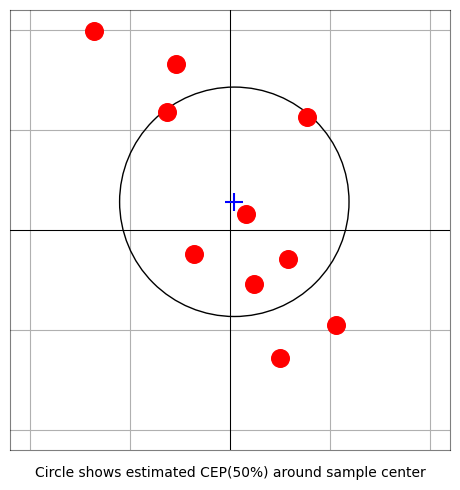

In [19]:
p = plotGroup(g)

## Simulations to Validate Statistics

In [21]:
# We can do this with the Python Group class defined above, but it's slow:
groupSize = 5           # Number of shots per group
simulations = 100_000    # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots

sim = [Group(groupSize, sigma=simulationSigma) for i in range(0, simulations)]  # Run simulations
print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups: ***"
    f"\nMean estimated sigma = {np.mean([s.sigmaEstimate for s in sim]):.4f} vs true sigma = {simulationSigma}   <-- Mean estimate should converge to true as #simulations increases"
    f"\nTrue sigma was above the upper {(1-sim[0].confidenceInterval)/2:.0%} Confidence Interval on estimated sigma "
    f"{sum(1 for s in sim if s.sigmaUpperConfidence < simulationSigma)/len(sim):.1%} of the time.\t<-- Should match"
    f"\nSample center distance from true center exceeded estimated median distance {sum(1 for s in sim if s.d2c > s.d2cMedian)/len(sim):.1%} of the time.\t<-- Should be 50%")

 *** Based on 100,000 simulated 5-shot groups: ***
Mean estimated sigma = 0.9994 vs true sigma = 1.0   <-- Mean estimate should converge to true as #simulations increases
True sigma was above the upper 5% Confidence Interval on estimated sigma 5.0% of the time.	<-- Should match
Sample center distance from true center exceeded estimated median distance 49.9% of the time.	<-- Should be 50%


### Fast Simulations (Cython)

In [4]:
%load_ext cython

In [7]:
groupSize = 5           # Number of shots per group
simulations = 10_000_000    # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots
simConfidence = 0.9

sigmaEstimate, sigmaUpperConfidence = runSim(groupSize, simulations,
                                              sigma=simulationSigma, confidenceInterval=simConfidence)

print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups: ***"
    f"\nMean estimated sigma = {np.mean(sigmaEstimate):.4f} vs true sigma = {simulationSigma}   <-- Mean estimate should converge to true as #simulations increases"
    f"\nTrue sigma was above the upper {(1-simConfidence)/2:.0%} Confidence Interval on estimated sigma "
    f"{sum(1 for s in sigmaUpperConfidence if s < simulationSigma)/simulations:.1%} of the time.\t<-- Should match")

 *** Based on 10,000,000 simulated 5-shot groups: ***
Mean estimated sigma = 0.9938 vs true sigma = 1.0   <-- Mean estimate should converge to true as #simulations increases
True sigma was above the upper 5% Confidence Interval on estimated sigma 5.0% of the time.	<-- Should match


### Faster Multi-threaded Cython

In [ ]:
%%cython
# distutils: extra_compile_args=/openmp
import numpy as np
import math
from scipy.stats.distributions import chi2
from libc.math cimport sqrt
cimport cython
from cython.parallel import prange

@cython.boundscheck(False)  # Doesn't check array bounds
@cython.wraparound(False)
@cython.cdivision(True)  # Doesn't spend time checking for zero divisors
def runSimMP(int numShots, Py_ssize_t numSims, double sigma = 1.0, double confidenceInterval = 0.9):
    cdef double[:] sigmaEstimate = np.zeros(numSims, np.double)
    cdef double[:] sigmaUpperConfidence = np.zeros(numSims, np.double)

    cdef double[:,:,:] shots = np.random.normal(scale=sigma, size=(numSims, numShots, 2)).astype(np.double)

    cdef int degrees = 2*(numShots-1)  # Degrees of freedom (for estimators)
    cdef double d = degrees+1
    cdef double cG = 1/math.exp(math.log(math.sqrt(2/(d-1))) + math.lgamma(d/2) - math.lgamma((d-1)/2))
    cdef double chiNorm = 1/chi2.ppf((1-confidenceInterval)/2, degrees)

    cdef double [:, :] centeredShots    # Shots shifted so that their centroid coordinates = (0,0)
    cdef double [:] radii = np.zeros(numShots, np.double)  # Radius (distance) of each shot from centroid
    cdef double sumR2                   # Sum of radii squared
    cdef double xbar, ybar
    cdef Py_ssize_t s, i
    for s in prange(numSims, nogil=True):#, schedule='static'):#, num_threads=4):
        # Compute sampleCenter = [xbar, ybar]
        xbar = ybar = 0
        for i in range(numShots):
            xbar = xbar+ shots[s, i, 0]
            ybar = ybar+ shots[s, i, 1]
        xbar = xbar/numShots
        ybar = ybar/numShots
        sumR2 = 0
        for i in range(numShots):
            sumR2 = sumR2+ (shots[s, i, 0] - xbar)**2 + (shots[s, i, 1] - ybar)**2
        sigmaEstimate[s] = cG * sqrt(sumR2 / degrees)    # Unbiased Rayleigh parameter estimate
        sigmaUpperConfidence[s] = sqrt(sumR2 * chiNorm)  # Upper bound of confidence interval on estimate
        
    return sigmaEstimate, sigmaUpperConfidence


In [ ]:
groupSize = 5           # Number of shots per group
simulations = 10_000_000    # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots
simConfidence = 0.9

sigmaEstimate, sigmaUpperConfidence = runSimMP(groupSize, simulations,
                                              sigma=simulationSigma, confidenceInterval=simConfidence)

print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups: ***"
    f"\nMean estimated sigma = {np.mean(sigmaEstimate):.4f} vs true sigma = {simulationSigma}   <-- Mean estimate should converge to true as #simulations increases"
    f"\nTrue sigma was above the upper {(1-simConfidence)/2:.0%} Confidence Interval on estimated sigma "
    f"{sum(1 for s in sigmaUpperConfidence if s < simulationSigma)/simulations:.1%} of the time.\t<-- Should match")

 *** Based on 10,000,000 simulated 5-shot groups: ***
Mean estimated sigma = 1.0001 vs true sigma = 1.0   <-- Mean estimate should converge to true as #simulations increases
True sigma was above the upper 5% Confidence Interval on estimated sigma 5.0% of the time.	<-- Should match


# Hit Probability – Rectangular Targets

Given sigma, we can use numerical integration to find the probability of hitting a particular target.  Here we'll compute the probability of hitting a rectangular target that is 2MOA high and 1MOA wide, with a gun that shoots $\sigma_x=1.5\text{MOA}$, $\sigma_y=0.6\text{MOA}$.

In [64]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy import integrate

sigmaX, sigmaY = 1.5, 0.6
targetX, targetY = 1.0, 2.0

def pdf(x,y):
    return multivariate_normal.pdf([x,y], mean=[0,0], cov=[[sigmaX**2, 0], [0, sigmaY**2]])

hit_probability, err = integrate.nquad(pdf, [[-targetX/2.0, targetX/2.0], [-targetY/2.0, targetY/2.0]])
print(f'Hit probability is {hit_probability:.1%}')

Hit probability is 23.6%


In [32]:
# Simulation to verify:
numShots = 1_000_000
shotsX = np.random.normal(scale=sigmaX, size=numShots)
shotsY = np.random.normal(scale=sigmaY, size=numShots)
hits = sum(1 for s in range(numShots) if ((abs(shotsX[s]) < targetX/2.0) and (abs(shotsY[s]) < targetY/2.0)))/numShots
print(f'Simulation target hit rate is {hits:.1%}')

Simulation target hit rate is 23.6%


## Visualization

Here's a simulation and plot of shots from a gun with that precision against that target.

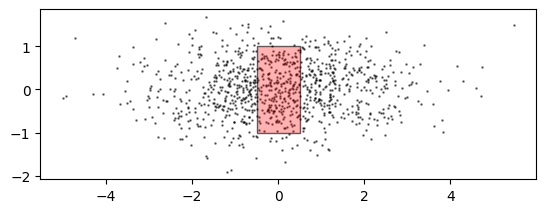

In [62]:
from matplotlib.patches import Polygon
numShots = 1000
shotsX = np.random.normal(scale=sigmaX, size=numShots)
shotsY = np.random.normal(scale=sigmaY, size=numShots)

ax = plt.gca()
ax.set_aspect('equal')
ax.scatter(shotsX, shotsY, s=0.7, color=[0,0,0,.5])
target_vertices = ((-targetX/2,-targetY/2), (targetX/2,-targetY/2), (targetX/2,targetY/2), (-targetX/2,targetY/2))
ax.add_patch(Polygon(target_vertices, closed=True, edgecolor=[0,0,0,.6], facecolor=[1,0,0,.3]))
plt.show()
#plt.savefig('TargetSim', dpi=500, bbox_inches='tight')
#plt.savefig('TargetSim.svg', format='svg', bbox_inches='tight')

## Unit Rectangle Hit Probabilities

In [20]:
sigmaX = 2
sigmaY = 1

print(f'Rectangle +/-1 sigma hit probability is {integrate.nquad(pdf, [[-sigmaX, sigmaX], [-sigmaY, sigmaY]])[0]:.2%}\n'
      f'Rectangle +/-2 sigma hit probability is {integrate.nquad(pdf, [[-2*sigmaX, 2*sigmaX], [-2*sigmaY, 2*sigmaY]])[0]:.2%}\n'
      f'Rectangle +/-3 sigma hit probability is {integrate.nquad(pdf, [[-3*sigmaX, 3*sigmaX], [-3*sigmaY, 3*sigmaY]])[0]:.2%}')

Rectangle +/-1 sigma hit probability is 46.61%
Rectangle +/-2 sigma hit probability is 91.11%
Rectangle +/-3 sigma hit probability is 99.46%


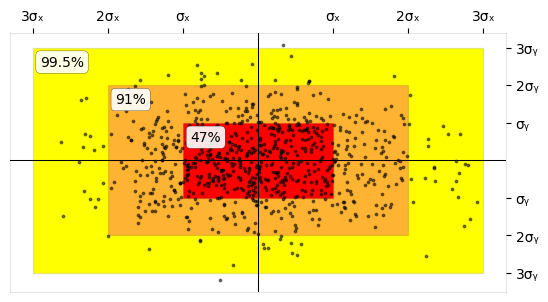

In [46]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

numShots = 800
shotsX = np.random.normal(scale=sigmaX, size=numShots)
shotsY = np.random.normal(scale=sigmaY, size=numShots)

ax = plt.gca()
ax.set_aspect('equal')
ax.scatter(shotsX, shotsY, s=3, color=[0,0,0,.5])
target_vertices = ((-sigmaX, -sigmaY), (sigmaX, -sigmaY), (sigmaX, sigmaY), (-sigmaX, sigmaY))
ax.add_patch(Polygon(target_vertices, closed=True, edgecolor=[0,0,0,.1], facecolor=[1,0,0,1] ,zorder=-1))
target_vertices = ((-2*sigmaX, -2*sigmaY), (2*sigmaX, -2*sigmaY), (2*sigmaX, 2*sigmaY), (-2*sigmaX, 2*sigmaY))
ax.add_patch(Polygon(target_vertices, closed=True, edgecolor=[0,0,0,.1], facecolor=[1,.7,.2,1], zorder=-2))
target_vertices = ((-3*sigmaX, -3*sigmaY), (3*sigmaX, -3*sigmaY), (3*sigmaX, 3*sigmaY), (-3*sigmaX, 3*sigmaY))
ax.add_patch(Polygon(target_vertices, closed=True, edgecolor=[0,0,0,.1], facecolor=[1,1,0,1], zorder=-3))
ax.text(-5.8,2.8,"99.5%", ha='left', va='top',bbox=dict(facecolor=[1,1,1,.9], boxstyle='round', lw=0.2))
ax.text(-3.8,1.8,"91%", ha='left', va='top',bbox=dict(facecolor=[1,1,1,.9], boxstyle='round', lw=0.2))
ax.text(-1.8,0.8,"47%", ha='left', va='top',bbox=dict(facecolor=[1,1,1,.9], boxstyle='round', lw=0.2))

for s in ax.spines.values():
    s.set_color([0,0,0,.1])
ax.axhline(0, color='k', lw=0.75)
ax.axvline(0, color='k', lw=0.75)
ax.xaxis.tick_top()  # Put x axis on top, not bottom
ax.set_xticks([-6, -4, -2, 2, 4, 6])
ax.set_xticklabels(['3σₓ', '2σₓ', 'σₓ', 'σₓ', '2σₓ', '3σₓ'], va='bottom')
ax.yaxis.tick_right()
ax.set_yticks([-3, -2, -1, 1, 2, 3])
ax.set_yticklabels(['3σᵧ', '2σᵧ', 'σᵧ', 'σᵧ', '2σᵧ', '3σᵧ'], ha='left')

plt.show()
#plt.savefig('SigmaRectangles', dpi=500, bbox_inches='tight')
#plt.savefig('SigmaRectangles.svg', format='svg', bbox_inches='tight')

# Simulations to Validate CEP

Given sigma ($\sigma$), CEP(p) = $\sigma \sqrt{-2 \ln(1-p)}$ is the radius of circle that should cover proportion *p* of shots (when centered at the true center of the distribution).

In [15]:
import math
import numpy as np

# Simulation, known sigma and known center, to check circular CEP(p) formula
numShots = 100_000
sigma = 2.0 # Sigma to use to generate random shots
p = 0.3     # Proportion of shots to cover with circle
CEPradius = sigma * math.sqrt(-2 * math.log(1-p))
shots = np.random.normal(scale=sigma, size=[numShots, 2])
print(f'CEP({p:.0%}) formula for sigma {sigma} gives covering circle radius {CEPradius:.3f}.\n'
      f'Simulation confirms that circle covers {sum(1 for s in shots if (s[0]**2/(CEPradius**2) + s[1]**2/(CEPradius**2) < 1)) / numShots:.1%} of {numShots:,} sample shots.')

CEP(30%) formula for sigma 2.0 gives covering circle radius 1.689.
Simulation confirms that circle covers 30.1% of 100,000 sample shots.


## Elliptic Groups

This formula also works for elliptic shot groups (i.e., $\sigma_X \neq \sigma_Y$) if we calculate the ellipse radii (*a, b*) as:
* $a = \sigma_X \sqrt{-2 \ln(1-p)}$
* $b = \sigma_Y \sqrt{-2 \ln(1-p)}$

In [16]:
# Simulation to check elliptic CEP(p) formula, known sigmas and known center
numShots = 1_000_000
sigmaX = 10.0
sigmaY = 1.0
p = 0.7     # Proportion of shots to cover with circle
CEPradiusX = sigmaX * math.sqrt(-2 * math.log(1-p))
CEPradiusY = sigmaY * math.sqrt(-2 * math.log(1-p))
shotsX = np.random.normal(scale=sigmaX, size=numShots)
shotsY = np.random.normal(scale=sigmaY, size=numShots)
print(f'CEP({p:.0%}) for elliptic sigmas ({sigmaX}, {sigmaY}) gives covering ellipse radii ({CEPradiusX:.3f}, {CEPradiusY:.3f}).\n'
      f'Simulation confirms that ellipse covers {sum(1 for s in range(numShots) if (shotsX[s]**2/(CEPradiusX**2) + shotsY[s]**2/(CEPradiusY**2) < 1)) / numShots:.1%} of {numShots:,} sample shots.')

CEP(70%) for elliptic sigmas (10.0, 1.0) gives covering ellipse radii (15.518, 1.552).
Simulation confirms that ellipse covers 70.1% of 1,000,000 sample shots.


## Covering Circle for Elliptic Groups

If we want to find a circle to cover an elliptic group, we might start by looking at a circle with radius based on the mean variance:
$$r^2 = \frac{\sigma_X^2+\sigma_Y^2}{2}$$

It turns out that this overestimates the size of the covering circle for p < 80%, and underestimates it for p > 80%, with the error increasing both (1) with the eccentricity of the ellipse, and (2) with the distance of the probability from 80%.  (Why 80%?  I haven't worked out the math, but I suspect that inflection point is actually $\sqrt{2/\pi}$, which is the mean of the half normal distribution.)

In [39]:
# Can we circularize the covering ellipse using the mean of varianceX and varianceY?
p = 0.3     # Proportion of shots to cover with circle
sigmaMean = math.sqrt((sigmaX**2 + sigmaY**2)/2.0)  # Root mean variance
CEPradius = sigmaMean * math.sqrt(-2 * math.log(1-p))
print(f'CEP({p:.0%}) for root mean variance {sigmaMean:.3f} suggests covering circle radius {CEPradius:.3f}.\n'
      f'Simulation shows that circle covers {sum(1 for s in range(numShots) if (shotsX[s]**2/(CEPradius**2) + shotsY[s]**2/(CEPradius**2) < 1)) / numShots:.1%} of {numShots:,} sample shots.')

CEP(30%) for root mean variance 7.106 suggests covering circle radius 6.002.
Simulation shows that circle covers 44.6% of 100,000 sample shots.


To get the covering circle radius exactly, we have to model the random variable $S = R^2 = X^2 + Y^2$.  In this case, $X^2 \sim \mathrm{Gamma}(1/2,\frac{1}{2\sigma^2_X})$, similarly for $Y^2$, and it turns out that to get the cumulative distribution we have to resort to numerical integration.  The derivation of this is esoteric, but here is the code:

In [41]:
from scipy.special import hyp1f1

def radius_squared_pdf(sigmaX, sigmaY, S):
    """PDF for sum of squared normal variables"""
    a = 1/(2*(sigmaX**2))
    b = 1/(2*(sigmaY**2))
    hyp1f1Res = hyp1f1(0.5, 1, (a-b)*S)  # Confluent hypergeometric function
    pdf = (a**(0.5)) * (b**(0.5)) * np.exp(-S*a) * hyp1f1Res
    return pdf

def elliptic_covering_radius(sigmaX, sigmaY, p):
    """Use numerical integration of PDF to find radius of circle that should cover proportion p of samples."""
    Smax = 3 * max(sigmaX, sigmaY)  # We'll start looking out 3 sigmas
    # The PDF here is monotonically decreasing, so we'll set Smax large enough to get density < 1e-6
    while radius_squared_pdf(sigmaX, sigmaY, Smax) > 1e-6:
        Smax = 3 * Smax
    integration_steps = 10_000
    dS = Smax / integration_steps
    S = np.linspace(start=dS, stop=Smax, num=integration_steps) # squared radius to evaluate
    pdf = radius_squared_pdf(sigmaX, sigmaY, S)     
    cdf = np.cumsum(pdf*dS)  # Integrate PDF

    idx = np.argmin(np.abs(cdf-p))
    return np.sqrt(S[idx])

p = 0.3
CEPradius = elliptic_covering_radius(sigmaX, sigmaY, p)
print(f'{p:.0%} covering circle for sigmas ({sigmaX}, {sigmaY}) has radius {CEPradius:.3f}.\n'
      f'Simulation confirms that circle covers {sum(1 for s in range(numShots) if (shotsX[s]**2/(CEPradius**2) + shotsY[s]**2/(CEPradius**2) < 1)) / numShots:.1%} of {numShots:,} sample shots.')

30% covering circle for sigmas (10.0, 1.0) has radius 4.065.
Simulation confirms that circle covers 30.6% of 1,000,000 sample shots.


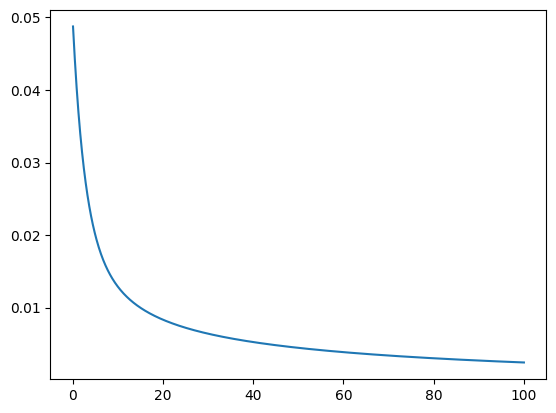

In [6]:
# Visualize PDF
import matplotlib.pyplot as plt
Smax = 100
steps = 1_000
dS = Smax / steps
S = np.linspace(start=dS, stop=Smax, num=steps) # squared radius to evaluate
pdf = radius_squared_pdf(sigmaX, sigmaY, S)
plt.plot(S, pdf)
plt.show()

### Error from single sigma estimate

If we have a truly asymmetric process (i.e., $\sigma_x \neq \sigma_y$), but we estimate a single sigma using the Rayleigh estimator (which assumes that $\sigma_x = \sigma_y$), how far off will our CEP measures be?

In [102]:
import pandas as pd
numSims = 100_000
ratios = []
for varianceRatio in range(1, 12,3):
    sigmaX = varianceRatio
    sigmaY = 1.0
    # Generate simulated shots
    shotsX = np.random.normal(scale=sigmaX, size=numSims)
    shotsY = np.random.normal(scale=sigmaY, size=numSims)
    sigmaMean = math.sqrt((sigmaX**2 + sigmaY**2)/2.0)
    #sampleSigma = math.sqrt((np.sum(np.square(shotsX))+np.sum(np.square(shotsY)))/(2*numSims))  # Approx Equal to sigmaMean
    for p in np.arange(.2, 1, .1):
        r = [varianceRatio, sigmaMean, p]
        CEPradius = elliptic_covering_radius(sigmaX, sigmaY, p)  # Correct covering radius
        r.append(CEPradius)
        r.append(sum(1 for s in range(numSims) if (shotsX[s]**2/(CEPradius**2) + shotsY[s]**2/(CEPradius**2) < 1)) / numSims)  # Coverage
        CEPradius = sigmaMean * math.sqrt(-2 * math.log(1-p))  # Covering radius assuming sigmaMean
        r.append(CEPradius)
        meanCoverage = sum(1 for s in range(numSims) if (shotsX[s]**2/(CEPradius**2) + shotsY[s]**2/(CEPradius**2) < 1)) / numSims
        r.append(meanCoverage)
        r.append(p-meanCoverage)  # Error
        ratios.append(r)
df = pd.DataFrame(ratios, columns=['VarianceRatio', 'sigmaMean', 'p', 'correctRadius', 'correctCoverage', 'meanRadius', 'meanCoverage', 'Error'])
df.to_clipboard()

#### Plot Error

In [62]:
%load_ext cython

In [73]:
%%cython
import numpy as np
from libc.math cimport sqrt, log
cimport cython

@cython.boundscheck(False)  # Doesn't check array bounds
@cython.wraparound(False)  # Doesn't allow negative indexing
@cython.cdivision(True)  # Doesn't spend time checking for zero divisors
def covering_error(double VarRatio, double p, Py_ssize_t numShots):
    """Difference between p and actual proportion of samples covered when using a circle based on the mean of variances"""
    cdef double sigmaX = VarRatio
    cdef double sigmaY = 1.0
    cdef double sigmaMean = sqrt((sigmaX**2 + sigmaY**2)/2.0)
    cdef double CEPradius = sigmaMean * sqrt(-2 * log(1-p))  # Covering radius assuming sigmaMean
    cdef double CEPradSqs = CEPradius**2
    # Generate simulated shots
    cdef double[:] shotsX = np.random.normal(scale=sigmaX, size=numShots).astype(np.double)
    cdef double[:] shotsY = np.random.normal(scale=sigmaY, size=numShots).astype(np.double)
    cdef double covered = 0
    cdef Py_ssize_t i
    for i in range(numShots):
        if (shotsX[i]**2/CEPradSqs + shotsY[i]**2/CEPradSqs) < 1:
            covered = covered + 1
    return p - covered / numShots

Content of stdout:
_cython_magic_7d336e699c3b789e61f727386c1d25d227e83541.c
C:\Users\David\.ipython\cython\_cython_magic_7d336e699c3b789e61f727386c1d25d227e83541.c(1473): warning C4005: '__pyx_nonatomic_int_type': macro redefinition
C:\Users\David\.ipython\cython\_cython_magic_7d336e699c3b789e61f727386c1d25d227e83541.c(1424): note: see previous definition of '__pyx_nonatomic_int_type'
   Creating library C:\Users\David\.ipython\cython\Users\David\.ipython\cython\_cython_magic_7d336e699c3b789e61f727386c1d25d227e83541.cp310-win_amd64.lib and object C:\Users\David\.ipython\cython\Users\David\.ipython\cython\_cython_magic_7d336e699c3b789e61f727386c1d25d227e83541.cp310-win_amd64.exp
Generating code
Finished generating code

In [100]:
numSims = 1_000_000
# Compile error values over a range of Variance Ratios and p-values
VarRatio, p = np.meshgrid(np.linspace(1, 10, 30), np.linspace(.2, .96, 30))
v = np.vectorize(covering_error)
error = v(VarRatio, p, numSims)

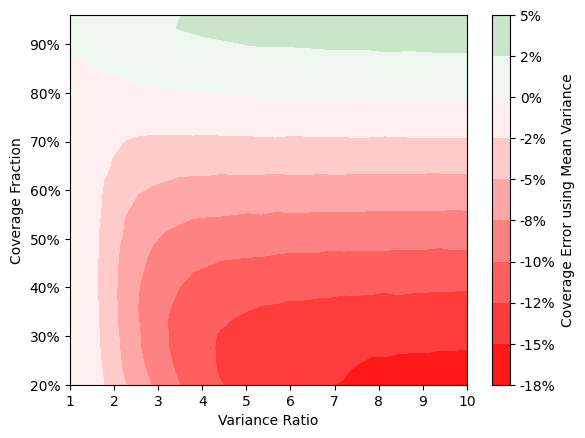

In [101]:
import matplotlib as mpl
import matplotlib.colors

colors = ['red', 'white', 'green']
values = [-.18, 0, .18]
norm = matplotlib.colors.Normalize(min(values), max(values))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", list(zip(norm(values), colors)))
fig, ax = plt.subplots()
cs = ax.contourf(VarRatio, p, error, cmap=cmap, norm=norm)
ax.set_xlabel("Variance Ratio")
ax.set_ylabel("Coverage Fraction")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))
cbar = fig.colorbar(cs, format=lambda x, _: f'{x:.0%}')
cbar.ax.set_ylabel('Coverage Error using Mean Variance')
plt.show()

## Illustration of Covering Ellipse and Circle

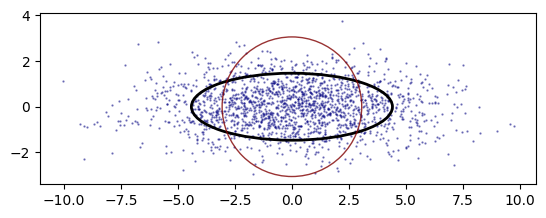

In [ ]:
from matplotlib.patches import Ellipse
numShots = 1800
sigmaX = 3.0
sigmaY = 1.0
p = 0.66     # Proportion of shots to cover with circle
CEPradiusX = sigmaX * math.sqrt(-2 * math.log(1-p))
CEPradiusY = sigmaY * math.sqrt(-2 * math.log(1-p))
sigmaMean = math.sqrt((sigmaX**2 + sigmaY**2)/2.0)
CEPradius = elliptic_covering_radius(sigmaX, sigmaY, p)
shotsX = np.random.normal(scale=sigmaX, size=numShots)
shotsY = np.random.normal(scale=sigmaY, size=numShots)

ax = plt.gca()
ax.set_aspect('equal')
ax.scatter(shotsX, shotsY, s=0.4, color=[0,0,.5,.5])
ax.add_patch(Ellipse([0,0], 2*CEPradiusX, 2*CEPradiusY, facecolor=[0,0,0,0], edgecolor=[0,0,0,1], lw=2))
ax.add_patch(plt.Circle([0,0], CEPradius, facecolor=[0,0,0,0], edgecolor=[0.5,0,0,.8], zorder=3))
plt.show()
#plt.savefig('Ellipse', dpi=500, bbox_inches='tight')

## Covering interval (CEP) in one dimension

In [42]:
# Covering interval in one dimension has a different functional form than in 2 dimensions:
import math
import numpy as np
from scipy.special import erfinv
numShots = 200_000
sigmaX = 2.0
p = 0.6     # Proportion of shots to cover with interval
normInterval = sigmaX * math.sqrt(2) * erfinv(p)
shotsX = np.random.normal(scale=sigmaX, size=numShots)
print(f'To cover {p:.0%} of variable with sigma {sigmaX}: Centered interval of length {normInterval:.3f} covers {sum(1 for s in range(numShots) if abs(shotsX[s]) < normInterval)/numShots:.1%}')

To cover 60% of variable with sigma 2.0: Centered interval of length 1.683 covers 60.1%


# Order Statistics

In [38]:
class OrderStatistics(Group):
    """
    Order statistics are an alternate way of estimating sigma.
    This subclass implements the calculations so that we can validate them.
    """
    sortedShots: list[int]                  # Index of shot by radius, small to large
    orderSampleR2: float                    # Estimate of sum radii squared
    sigmaOrderStatEstimate: float           # Rayleigh parameter estimate
    sigmaOrderStatUpperConfidence: float    # Upper bound of confidenceInterval on sigmaOrderStatEstimate

    def computeOrderStatistics(self) -> float:
        """
        Compute sigma using Order Statistics approach.
        Only defined here for n = 3, 5, or 10.
        """
        def Rstat(m: int):
            """Return mth smallest radii -- i.e., order statistic R(m)"""
            if m > self.n:
                raise Exception(f"Tried to access order statistic {m} on group size {self.n}")
            return self.radii[self.sortedShots][m-1]
        
        self.sortedShots = np.argsort(self.radii)  # Index of shot by radius, small to large
        if self.n == 3:
            self.orderSampleR2 = 0.66 * Rstat(3)**2
        elif self.n == 5:
            self.orderSampleR2 = 0.7792 * Rstat(4)**2
        elif self.n == 10:
            self.orderSampleR2 = 0.4913 * Rstat(6)**2 + 0.3030 * Rstat(9)**2
        else:
            raise Exception(f"No order statistics defined for group size n={self.n}\nOnly for n = 3, 5, or 10.")
        self.orderSampleSumR2 = self.n * self.orderSampleR2
        self.sigmaOrderStatEstimate = Group.cGauss(self.degrees+1) * math.sqrt(self.orderSampleSumR2 / self.degrees)
        self.sigmaOrderStatUpperConfidence = math.sqrt(self.orderSampleSumR2 / (chi2.ppf(0.05, self.degrees)))
        return self.sigmaOrderStatEstimate

In [33]:
# Example estimating sigma using order statistics:
gOS = OrderStatistics(10)
print(f'Sigma estimate using Rayleigh estimator: {gOS.sigmaEstimate}\n'
      f'Sigma estimate using Order Statistics:  {gOS.computeOrderStatistics()}')

Sigma estimate using Rayleigh estimator: 1.0948265273926074
Sigma estimate using Order Statistics:  1.1008539269973991


## Simulations to Validate Order Statistics

### 10-shot groups

In [54]:
# Simulation to validate OrderStatistics
groupSize = 10          # Number of shots per group
simulations = 100_000   # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots
simConfidence = 0.9     # Confidence interval to compute

simOrderStats = [OrderStatistics(groupSize, sigma=simulationSigma, confidenceInterval=simConfidence) for i in range(0, simulations)]  # Run simulations
efficientEstimates = [s.sigmaEstimate for s in simOrderStats]
efficientEstimateVariance = np.var(efficientEstimates)
orderStatEstimates = [s.computeOrderStatistics() for s in simOrderStats]  # This causes each simulation to run orderStatistics
orderStatEstimateVariance = np.var(orderStatEstimates)
print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups, with true sigma {simulationSigma}: ***"
    f"\nMax. Efficiency Estimator gives mean sigma = {np.mean(efficientEstimates):.3f}  with variance = {efficientEstimateVariance:.4f}"
        f"\tUpper {(1-simConfidence)/2:.0%} Confidence < Sigma {sum(1 for s in simOrderStats if s.sigmaUpperConfidence < simulationSigma)/simulations:.2%}"
    f"\nOrder Statistic Estimator gives mean sigma = {np.mean(orderStatEstimates):.3f}  with variance = {orderStatEstimateVariance:.4f}"
        f"\tUpper {(1-simConfidence)/2:.0%} Confidence < Sigma {sum(1 for s in simOrderStats if s.sigmaOrderStatUpperConfidence < simulationSigma)/simulations:.2%}"
    f"\n\tOrder Stat Efficiency is ratio of variances = {(efficientEstimateVariance/orderStatEstimateVariance):.1%}")

 *** Based on 100,000 simulated 10-shot groups, with true sigma 1.0: ***
Max. Efficiency Estimator gives mean sigma = 1.000  with variance = 0.0281	Upper 5% Confidence < Sigma 4.99%
Order Statistic Estimator gives mean sigma = 1.000  with variance = 0.0324	Upper 5% Confidence < Sigma 6.16%
	Order Stat Efficiency is ratio of variances = 86.9%


### 5-shot groups

In [53]:
# Simulation to validate OrderStatistics
groupSize = 5           # Number of shots per group
simulations = 100_000   # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots
simConfidence = 0.9     # Confidence interval to compute

simOrderStats = [OrderStatistics(groupSize, sigma=simulationSigma, confidenceInterval=simConfidence) for i in range(0, simulations)]  # Run simulations
efficientEstimates = [s.sigmaEstimate for s in simOrderStats]
efficientEstimateVariance = np.var(efficientEstimates)
orderStatEstimates = [s.computeOrderStatistics() for s in simOrderStats]  # This causes each simulation to run orderStatistics
orderStatEstimateVariance = np.var(orderStatEstimates)
print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups, with true sigma {simulationSigma}: ***"
    f"\nMax. Efficiency Estimator gives mean sigma = {np.mean(efficientEstimates):.3f}  with variance = {efficientEstimateVariance:.4f}"
        f"\tUpper {(1-simConfidence)/2:.0%} Confidence < Sigma {sum(1 for s in simOrderStats if s.sigmaUpperConfidence < simulationSigma)/simulations:.2%}"
    f"\nOrder Statistic Estimator gives mean sigma = {np.mean(orderStatEstimates):.3f}  with variance = {orderStatEstimateVariance:.4f}"
        f"\tUpper {(1-simConfidence)/2:.0%} Confidence < Sigma {sum(1 for s in simOrderStats if s.sigmaOrderStatUpperConfidence < simulationSigma)/simulations:.2%}"
    f"\n\tOrder Stat Efficiency is ratio of variances = {(efficientEstimateVariance/orderStatEstimateVariance):.1%}")

 *** Based on 100,000 simulated 5-shot groups, with true sigma 1.0: ***
Max. Efficiency Estimator gives mean sigma = 0.998  with variance = 0.0645	Upper 5% Confidence < Sigma 5.11%
Order Statistic Estimator gives mean sigma = 1.008  with variance = 0.0815	Upper 5% Confidence < Sigma 6.43%
	Order Stat Efficiency is ratio of variances = 79.1%


### 3-shot groups

In [52]:
# n = 3 ... at this size a single order statistic is a very coarse estimator
groupSize = 3           # Number of shots per group
simulations = 100_000   # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots
simConfidence = 0.9     # Confidence interval to compute

simOrderStats = [OrderStatistics(groupSize, sigma=simulationSigma, confidenceInterval=simConfidence) for i in range(0, simulations)]  # Run simulations
efficientEstimates = [s.sigmaEstimate for s in simOrderStats]
efficientEstimateVariance = np.var(efficientEstimates)
orderStatEstimates = [s.computeOrderStatistics() for s in simOrderStats]  # This causes each simulation to run orderStatistics
orderStatEstimateVariance = np.var(orderStatEstimates)
print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups, with true sigma {simulationSigma}: ***"
    f"\nMax. Efficiency Estimator gives mean sigma = {np.mean(efficientEstimates):.3f}  with variance = {efficientEstimateVariance:.4f}"
        f"\tUpper {(1-simConfidence)/2:.0%} Confidence < Sigma {sum(1 for s in simOrderStats if s.sigmaUpperConfidence < simulationSigma)/simulations:.2%}"
    f"\nOrder Statistic Estimator gives mean sigma = {np.mean(orderStatEstimates):.3f}  with variance = {orderStatEstimateVariance:.4f}"
        f"\tUpper {(1-simConfidence)/2:.0%} Confidence < Sigma {sum(1 for s in simOrderStats if s.sigmaOrderStatUpperConfidence < simulationSigma)/simulations:.2%}"
    f"\n\tOrder Stat Efficiency is ratio of variances = {(efficientEstimateVariance/orderStatEstimateVariance):.1%}")

 *** Based on 100,000 simulated 3-shot groups, with true sigma 1.0: ***
Max. Efficiency Estimator gives mean sigma = 1.000  with variance = 0.1322	Upper 5% Confidence < Sigma 5.01%
Order Statistic Estimator gives mean sigma = 1.040  with variance = 0.1490	Upper 5% Confidence < Sigma 4.59%
	Order Stat Efficiency is ratio of variances = 88.7%


## Fast order statistic simulations (Cython)

In [16]:
%load_ext cython

In [45]:
%%cython --cplus
import numpy as np
import math
from scipy.stats.distributions import chi2
from libcpp.algorithm cimport sort  # C++ sort seems to be fastest
from libc.math cimport sqrt
cimport cython

@cython.boundscheck(False)  # Doesn't check array bounds
@cython.wraparound(False)  # Doesn't allow negative indexing
@cython.cdivision(True)  # Doesn't spend time checking for zero divisors
def runSimOrderStats(int numShots, Py_ssize_t numSims, double sigma = 1.0, double confidenceInterval = 0.9):
    if numShots not in [3, 5, 10]:
        raise NotImplementedError(f"No order statistics defined for group size n={numShots}"
                                  f"\nOnly for n = 3, 5, or 10.")

    cdef double[:] sigmaEstimate = np.zeros(numSims, np.double)
    cdef double[:] sigmaUpperConfidence = np.zeros(numSims, np.double)

    # Index: [Simulation#, Shot#, Axis]
    cdef double[:,:,:] shots = np.random.normal(scale=sigma, size=(numSims, numShots, 2)).astype(np.double)

    cdef int degrees = 2*(numShots-1)  # Degrees of freedom (for estimators)
    cdef double d = degrees+1
    cdef double cG = 1/math.exp(math.log(math.sqrt(2/(d-1))) + math.lgamma(d/2) - math.lgamma((d-1)/2))
    cdef double chiNorm = 1/chi2.ppf((1-confidenceInterval)/2, degrees)

    cdef double sumR2                  # Sample sum R^2 based on order statistics
    cdef double xbar, ybar
    cdef Py_ssize_t i, s
    cdef double[:] radii2 = np.zeros(numShots, np.double)  # Radius squared of each shot
    for s in range(numSims):
        # Compute sampleCenter = [xbar, ybar]
        xbar = ybar = 0
        for i in range(numShots):
            xbar += shots[s, i, 0]
            ybar += shots[s, i, 1]
        xbar /= numShots
        ybar /= numShots
        # Compute radius for each shot
        for i in range(numShots):
            radii2[i] = (shots[s, i, 0] - xbar)**2 + (shots[s, i, 1] - ybar)**2
            sumR2 += radii2[i]
        # Sort radii
        sort(&radii2[0], (&radii2[0])+radii2.shape[0])
        if numShots == 3:
            sumR2 = 0.66 * radii2[3-1]
        elif numShots == 5:
            sumR2 = 0.7792 * radii2[4-1]
        else: # numShots == 10:
            sumR2 = 0.4913 * radii2[6-1] + 0.3030 * radii2[9-1]
        sumR2 = sumR2 * numShots
        sigmaEstimate[s] = cG * sqrt(sumR2 / degrees)

    return sigmaEstimate

In [55]:
groupSize = 10             # Number of shots per group
simulations = 1_000_000    # Number of groups to simulate
simulationSigma = 1.0      # Sigma to use when generating random shots

sigmaEstimate = runSimOrderStats(groupSize, simulations, sigma=simulationSigma, confidenceInterval=simConfidence)

print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups: ***"
    f"\nMean estimated sigma = {np.mean(sigmaEstimate):.4f} vs true sigma = {simulationSigma}   <-- Mean estimate should converge to true as #simulations increases")

 *** Based on 1,000,000 simulated 10-shot groups: ***
Mean estimated sigma = 0.9995 vs true sigma = 1.0   <-- Mean estimate should converge to true as #simulations increases
